In [1]:
import numpy as np
import pandas as pd
import splotch as sp
import scipy.stats as stats
import scipy.optimize as opti
#import numpy.polynomial as poly
import matplotlib.pyplot as plot
import scipy.interpolate as interp

Note: `splotch` is just a small matplotlib wrapper that we wrote with Robin Cook (PhD student at ICRAR while I was there), it bears no relevance to the abudance matching.

In [2]:
sp.use_style("/home/mbravo/Documents/pypati.style")

In [3]:
rng = np.random.default_rng(seed = 7)

I'm using my custom DEVILS-like lightcones, which have three separate fields of different areas. The observational catalogue I'm abudance-matching against comes from a single field of DEVILS (the only field I'm currently running the group finder), so the areas here are scale the number densities to the same standard.

In [4]:
D02area = 3.0397
D03area = 1.5010
D10area = 1.5036
DEVILSarea = D02area + D03area + D10area
Ymag_lim = 21.2

In [5]:
D10cat = pd.read_csv("/home/mbravo/Documents/Group_Finder/DEVILS_cats/DEVILS_D10_zY_all.csv")
D10cat = D10cat.loc[(D10cat["apmag_Y"] <= 21.2) & (D10cat["zBestType"] == "spec")]
D10cat

,UID,RAcen,DECcen,mask,artefactFlag,starFlag,apmag_Y_zcat,zBest,zBestSource,zBestType,flux_Y,flux_err_Y,apmag_Y
55,101503530681960736,150.353068,1.960748,0,0,0,21.031055,1.170456,DESI,spec,0.000014,9.766152e-08,21.031055
88,101497317352484144,149.731741,2.484186,0,0,0,20.952213,0.644902,DEVILS,spec,0.000015,2.710702e-08,20.952213
90,101497278152491232,149.727801,2.491239,0,0,0,20.831639,0.857890,DEVILS,spec,0.000017,1.280993e-07,20.831639
156,101497325272482640,149.732506,2.482599,0,0,0,20.806544,1.373500,ComparatOII,spec,0.000017,3.305652e-08,20.806544
187,101497115061946944,149.711671,1.946980,0,0,0,18.622104,0.123600,zCOSMOS,spec,0.000129,2.115342e-07,18.622104
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493613,101506902061674016,150.690210,1.674015,0,0,0,20.709326,0.362197,DEVILS,spec,0.000019,1.341969e-07,20.709326
493746,101506854941661504,150.685530,1.661580,0,0,0,20.701591,0.664869,DEVILS,spec,0.000019,1.300851e-07,20.701591
493750,101506853681661008,150.685369,1.660967,0,0,0,20.403140,0.664869,DEVILS,spec,0.000025,1.316387e-07,20.403140
493825,101506944542781600,150.694455,2.781499,0,0,0,21.010567,0.724328,DEVILS,spec,0.000014,1.118454e-07,21.010567


I understand that you have made your own random catalogues, right? The following catalogue is the equivalent I made from the DEVILS-D10 catalogue (file just above this)

In [6]:
D10rancat = pd.read_csv("/home/mbravo/Documents/Group_Finder/DEVILS_cats/DEVILS_D10_RandomCat_250205_v0.3.csv")
D10rancat

,UID,zBest
0,1,0.765054
1,2,0.437474
2,3,0.550673
3,4,0.806135
4,5,0.177487
...,...,...
15586577,15586578,0.405461
15586578,15586579,0.322294
15586579,15586580,0.569023
15586580,15586581,0.629454


This is simply a compilation of my 32 independent DEVILS-like lightcones into a signle file with just a few fields that are useful for for the calibration. The `oldID_` fields are the values from Stingray, the `ID_` are the new IDs that I generated with the code snipet I shared with you some time ago. The `completeness_selected` field is one I made to randomly select 90% of the galaxies (the completeness we have for DEVILS), the reason for having it as a field in the catalogue was simply to fix the selection and not having it randomly chosen each time I fixed/updated the abudance matching.

In [7]:
D10calcat = pd.read_csv("/home/mbravo/Documents/Group_Finder/LC_runs/DEVILS_CalCat.csv")
D10calcat = D10calcat.loc[D10calcat["Y_VISTA_ap_dust_total"] > 0]
msel_og = D10calcat["Y_VISTA_ap_dust_total"] <= Ymag_lim
comp_sel = rng.uniform(0, 1, len(D10calcat))
comp_sel = np.where(comp_sel >= 0.1, 1, 0)
D10calcat["completeness_selected"] = comp_sel
comp_sel = D10calcat["completeness_selected"] == 1
D10calcat

,oldID_galaxy,oldID_group,RA,Dec,zobs,SharkProp_ID,SharkProp_snapshot,SharkProp_subvolume,SharkProp_tile,Field,Stingray_flag,Y_VISTA_ap_dust_total,LCno,ID_galaxy,ID_group,completeness_selected
0,5,39725400000001,52.678470,-28.257040,0.594302,41,174,0,144,D03,0.0,19.203373,1,1,95510,1
1,8,-1,53.009530,-28.485160,0.584129,722,174,0,144,D03,0.0,20.857710,1,2,1,1
2,9,39725400000002,52.782597,-28.444748,0.596191,1748,174,0,144,D03,0.0,20.504768,1,3,95511,1
3,10,39725400000003,52.700584,-28.115602,0.598819,2807,174,0,144,D03,0.0,21.046793,1,4,95512,1
4,14,39725400000006,52.670673,-28.272299,0.596565,6902,174,0,144,D03,0.0,20.105902,1,5,95513,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141041,786843,11815500000059,36.197630,-4.938808,1.041707,7863,159,63,267,D02,0.0,21.363148,32,31219764,31036019,1
7141042,786847,11815500000061,36.349392,-5.157805,1.070308,814,159,63,267,D02,0.0,21.413258,32,31219765,31036020,1
7141043,786880,11814600000004,34.341015,-5.187326,1.073887,487,159,63,258,D02,0.0,21.340694,32,31219766,31036010,1
7141044,786899,11814600000020,35.163765,-4.699356,1.060427,3724,159,63,258,D02,0.0,20.595032,32,31219767,31036011,1


In [8]:
D10calcat.columns.values

array(['oldID_galaxy', 'oldID_group', 'RA', 'Dec', 'zobs', 'SharkProp_ID',
       'SharkProp_snapshot', 'SharkProp_subvolume', 'SharkProp_tile',
       'Field', 'Stingray_flag', 'Y_VISTA_ap_dust_total', 'LCno',
       'ID_galaxy', 'ID_group', 'completeness_selected'], dtype=object)

My approach to the random catalogue was simpler than the one used for GAMA, since we don't have a luminosity function for DEVILS and I may have wanted to take a few shortcuts &#x1F605;. I'm using a skewed Gaussian to model the N(z) from DEVILS-D10 (looks surprisingly reasonable), which I'm defining here to use for plotting later.

In [10]:
snorm = stats.skewnorm
sknorm_d = np.array((4.719143039641699, 0.17073951452671754, 0.4565196188657554))
linz = np.linspace(0.001, 2, 1001)

Again, we don't have the LF for DEVILS-D10. So instead of the more complex process I used for [my 2020 paper](https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.3026B/abstract), I'm abundance-matching by simply finding the $Y$-band mag shift I need to apply to all <span style="font-variant:small-caps;">shark</span> galaxies in a given redshift bin to match the number of galaxies expected in DEVILS-D10.

In [11]:
zbin = np.linspace(0, 2, 41)
zmid = (zbin[:-1] + zbin[1:]) / 2

nz_d = (np.histogram(D10rancat["zBest"], bins = zbin, density = False)[0] / 1024) / 0.9
nz_s = np.histogram(D10calcat.loc[msel_og, "zobs"], bins = zbin, density = False)[0].astype('float64')
nz_s *= (D10area / DEVILSarea) / 32
r = nz_d / nz_s

mdiff = np.zeros(len(zmid))
for i in range(len(zmid)):
    zsel = (D10calcat["zobs"] > zbin[i]) & (D10calcat["zobs"] < zbin[i + 1])
    nbin = np.sum(zsel)
    if nbin > 100:
        msubset = D10calcat.loc[zsel, "Y_VISTA_ap_dust_total"].to_numpy(copy = True)
        msubset = np.sort(msubset)
        nsel = np.sum(msubset <= Ymag_lim)
        idx = int(np.min([np.round(nsel * r[i]), nbin - 1]))
        mdiff[i] = Ymag_lim - msubset[idx]

/tmp/ipykernel_10856/532977794.py:7: RuntimeWarning: divide by zero encountered in divide
  r = nz_d / nz_s


Visualising the offsets in each redshift bin and fitting a spline through them. This is to have a smooth correction and avoid having discrete steps between redshift bins.

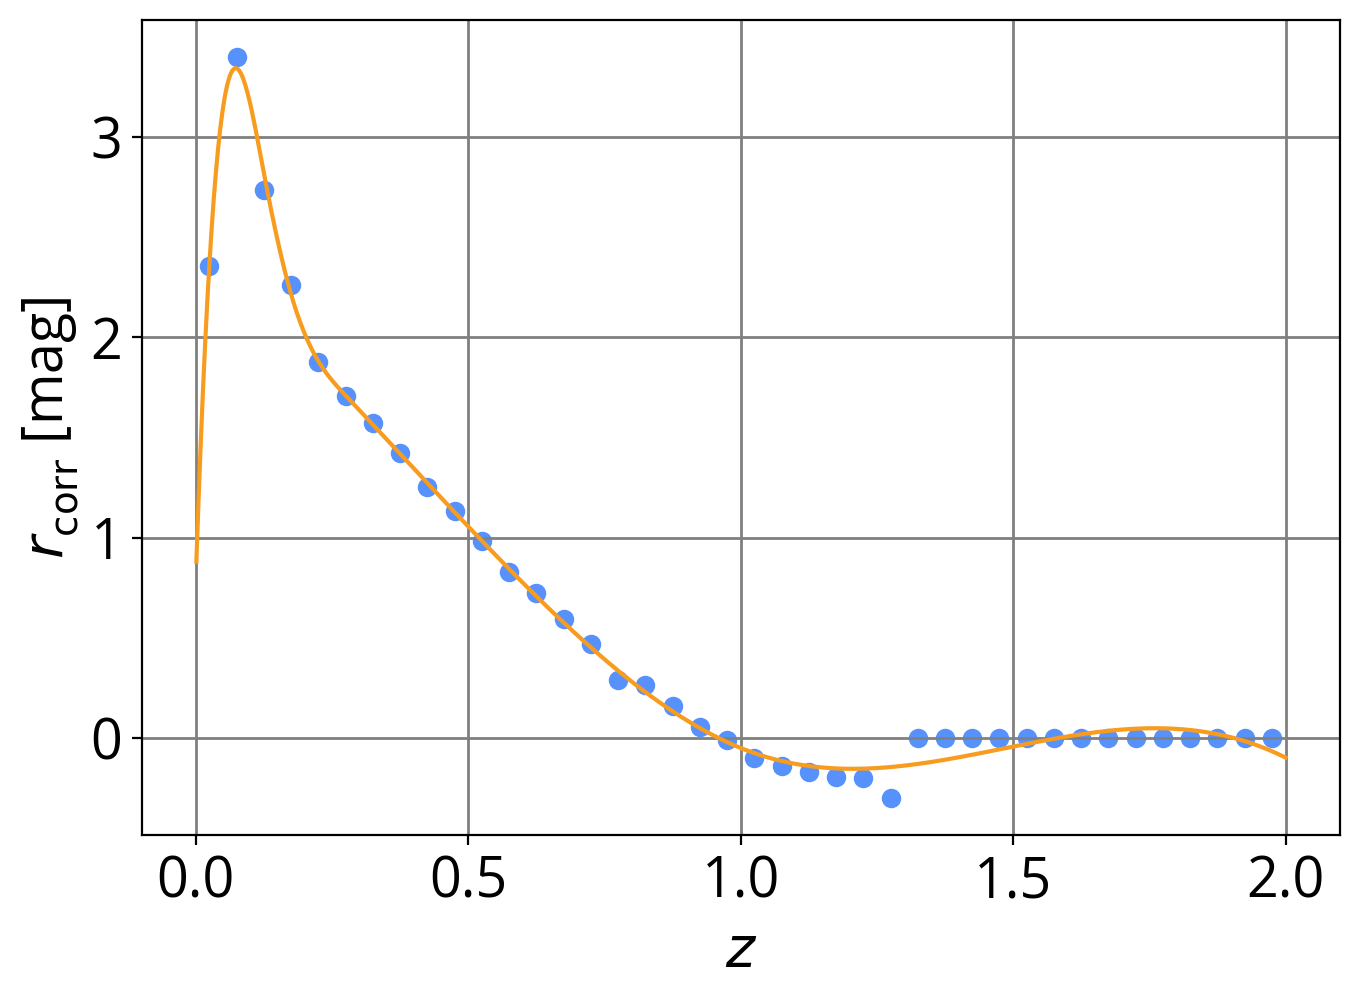

In [12]:
mdiff_spl = interp.UnivariateSpline(zmid, mdiff, k = 3, s = 0.1, ext = 0)

sp.scatter(zmid, mdiff)
sp.plot(linz, mdiff_spl(linz), c = "C1", xlabel = "$z$", ylabel = r"$r^{}_\mathrm{corr}$ [mag]")

plot.tight_layout()
plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_magcorr.pdf")
plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_magcorr.png")
plot.show()

Defining a corrected $Y$-mag and applying the DEVILS magnitude selection

In [14]:
D10calcat["Y_VISTA_ap_dust_total_magcorr"] = D10calcat["Y_VISTA_ap_dust_total"] + mdiff_spl(D10calcat["zobs"])
msel_corr = D10calcat["Y_VISTA_ap_dust_total_magcorr"] <= Ymag_lim

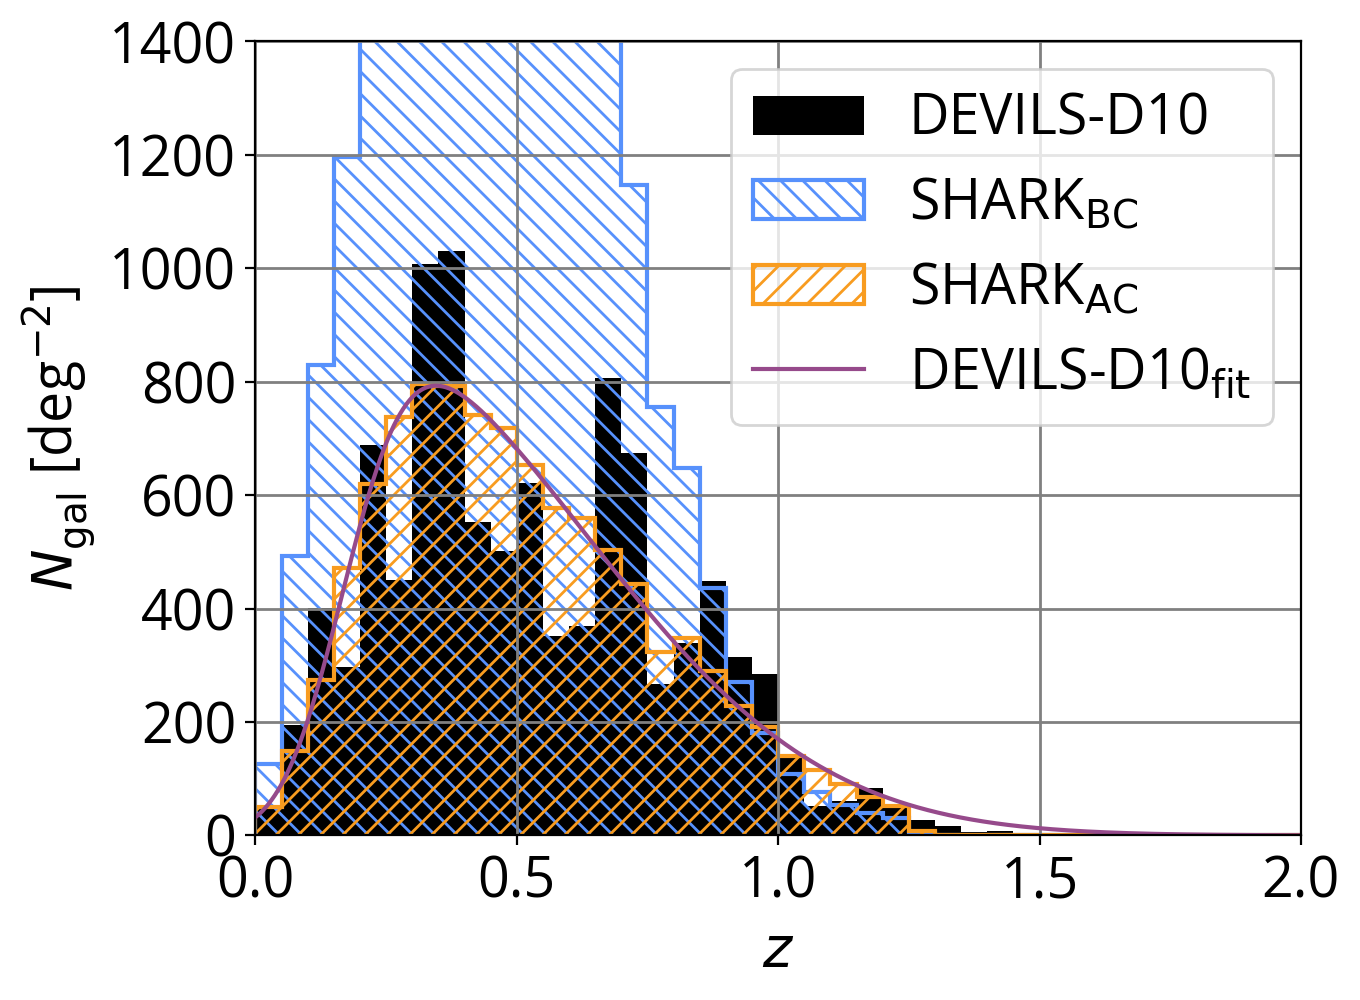

In [13]:
fscale = 1 - snorm.cdf(0, sknorm_d[0], sknorm_d[1], sknorm_d[2])

sp.hist(D10cat["zBest"].to_numpy(copy = True), bins = np.linspace(0,2,41), c = "k", hist_type = "stepfilled",
        scale = D10area, label = "DEVILS-D10", dens = False)
sp.hist(D10calcat.loc[msel_og & comp_sel, "zobs"].to_numpy(copy = True), bins = np.linspace(0, 2, 41),
        hist_type = "stepfilled", dens = False, scale = 32 * DEVILSarea, edgecolor = "C0", facecolor = "none",
        hatch = "\\\\\\", lw = 1.5, label = r"SHARK$_\mathrm{BC}$")
sp.hist(D10calcat.loc[msel_corr & comp_sel, "zobs"].to_numpy(copy = True), bins = np.linspace(0, 2, 41),
        hist_type = "stepfilled", dens = False, scale = 32 * DEVILSarea, edgecolor = "C1", facecolor = "none",
        hatch = "///", lw = 1.5, label = r"SHARK$_\mathrm{AC}$")
sp.plot(linz, snorm.pdf(linz, sknorm_d[0], sknorm_d[1], sknorm_d[2]) * len(D10cat) * 0.05 / D10area, c = "C3",
        xlim = (0, 2), ylim = (0, 1400), label = r"DEVILS-D10$_\mathrm{fit}$", xlabel = "$z$",
        ylabel = r"$N^{}_\mathrm{gal}$ [deg$^{-2}$]")
# That 0.05 factor is the bin width correction

plot.tight_layout()
plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz.pdf")
plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz.png")
plot.show()

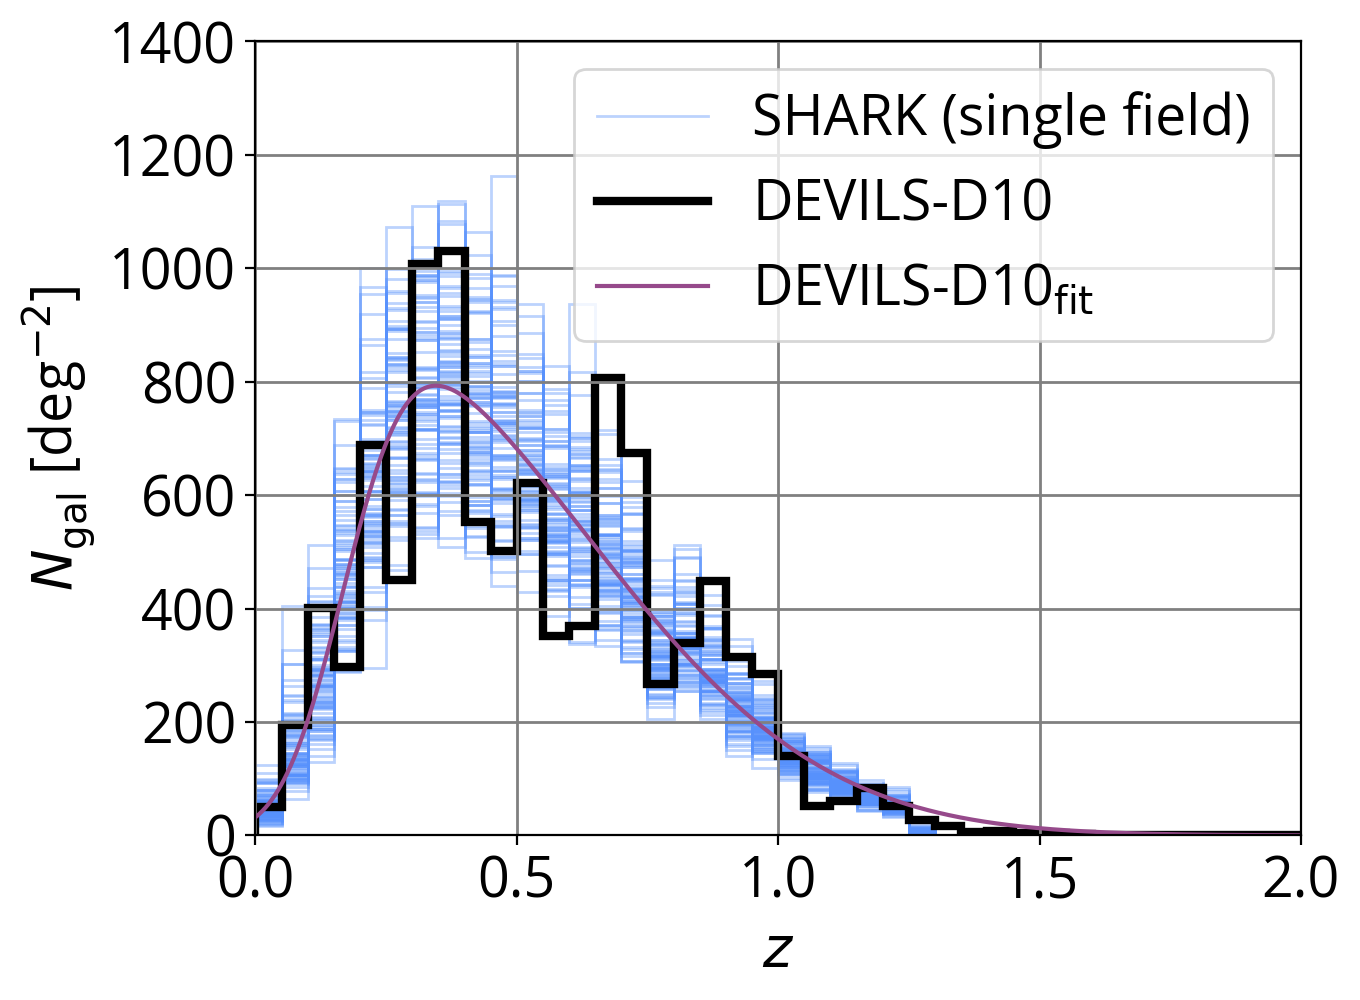

In [20]:
for i in range(32):
    for f in ["D02", "D03", "D10"]:
        fsel = (D10calcat["Field"] == f) & (D10calcat["LCno"] == i + 1) & msel_corr & comp_sel
        match f:
            case "D02":
                area_corr = D02area
            case "D03":
                area_corr = D03area
            case "D10":
                area_corr = D10area
        slab = None
        if (i == 0) & (f == "D10"):
            slab = "SHARK (single field)"
        sp.hist(D10calcat.loc[fsel, "zobs"].to_numpy(copy = True), bins = np.linspace(0, 2, 41), dens = False,
                color = "C0", alpha = 0.4, lw = 1, scale = area_corr, label = slab)
sp.hist(D10cat["zBest"].to_numpy(copy = True), bins = np.linspace(0, 2, 41), c = "k",
        lw = 3, scale = D10area, label = "DEVILS-D10", dens = False)
sp.plot(linz, snorm.pdf(linz, sknorm_d[0], sknorm_d[1], sknorm_d[2]) * len(D10cat) * 0.05 / D10area, c = "C3",
        xlim = (0, 2), ylim = (0, 1400), label = r"DEVILS-D10$_\mathrm{fit}$", xlabel = "$z$",
        ylabel = r"$N^{}_\mathrm{gal}$ [deg$^{-2}$]")
# That 0.05 factor is the bin width correction

plot.tight_layout()
plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz_allLC.pdf")
plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz_allLC.png")
plot.show()

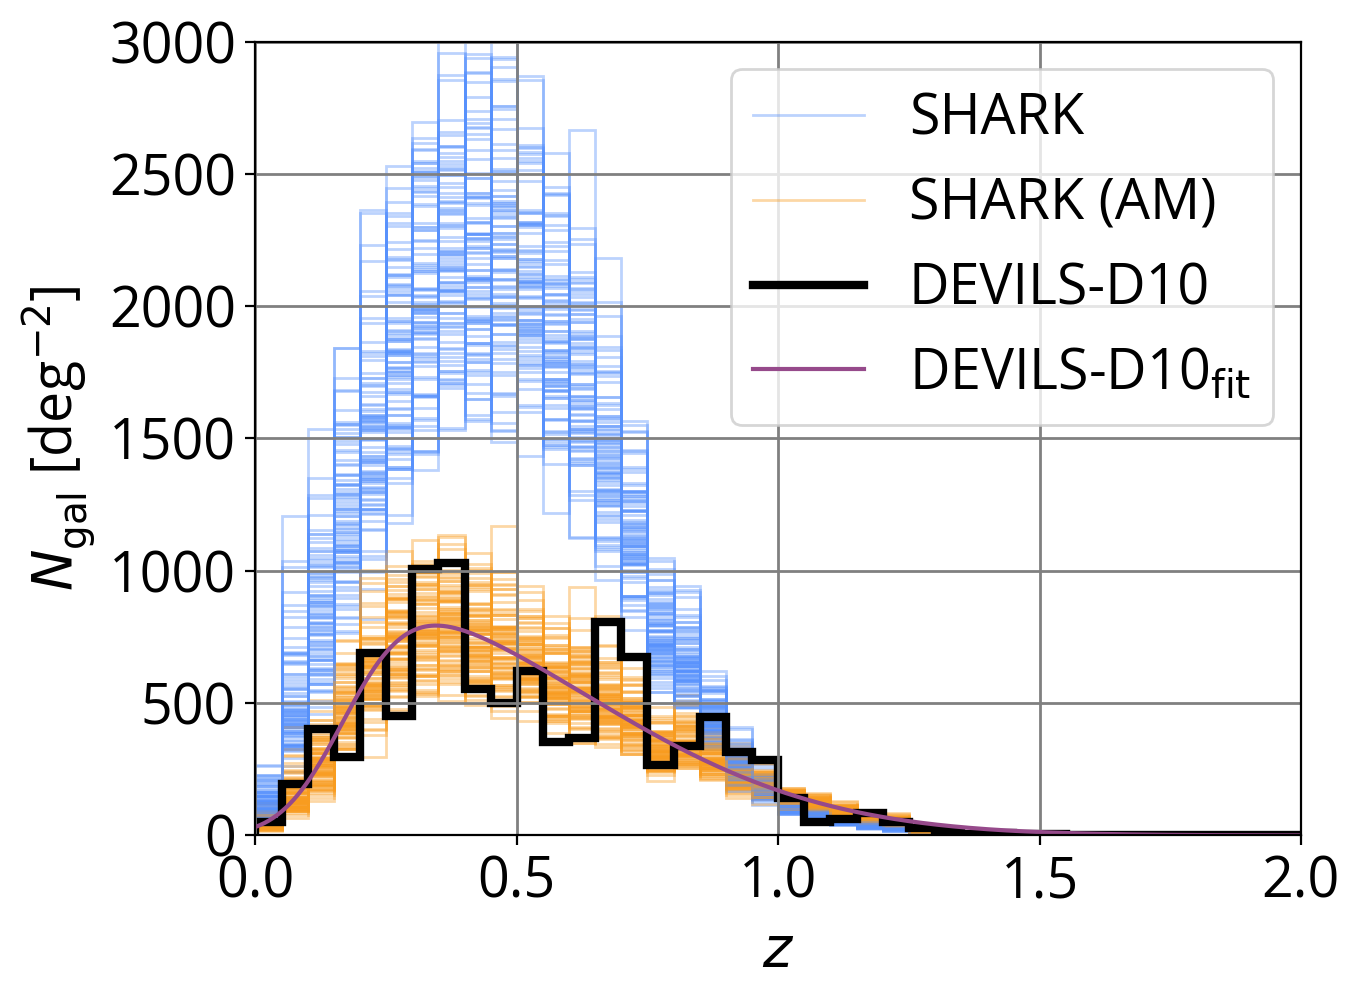

In [31]:
for i in range(32):
    for f in ["D02", "D03", "D10"]:
        fsel_og = (D10calcat["Field"] == f) & (D10calcat["LCno"] == i + 1) & msel_og & comp_sel
        fsel_corr = (D10calcat["Field"] == f) & (D10calcat["LCno"] == i + 1) & msel_corr & comp_sel
        match f:
            case "D02":
                area_corr = D02area
            case "D03":
                area_corr = D03area
            case "D10":
                area_corr = D10area
        slab = None
        if (i == 0) & (f == "D10"):
            slab = "SHARK"
        sp.hist(D10calcat.loc[fsel_og, "zobs"].to_numpy(copy = True), bins = np.linspace(0, 2, 41),
                dens = False, color = "C0", alpha = 0.4, lw = 1, scale = area_corr, label = slab)
        slab = None
        if (i == 0) & (f == "D10"):
            slab = "SHARK (AM)"
        sp.hist(D10calcat.loc[fsel_corr, "zobs"].to_numpy(copy = True), bins = np.linspace(0, 2, 41),
                dens = False, color = "C1", alpha = 0.4, lw = 1, scale = area_corr, label = slab)
sp.hist(D10cat["zBest"].to_numpy(copy = True), bins = np.linspace(0, 2, 41), c = "k",
        lw = 3, scale = D10area, label = "DEVILS-D10", dens = False)
sp.plot(linz, snorm.pdf(linz, sknorm_d[0], sknorm_d[1], sknorm_d[2]) * len(D10cat) * 0.05 / D10area, c = "C3",
        xlim = (0, 2), ylim = (0, 3000), label = r"DEVILS-D10$_\mathrm{fit}$", xlabel = "$z$",
        ylabel = r"$N^{}_\mathrm{gal}$ [deg$^{-2}$]")
# That 0.05 factor is the bin width correction

plot.tight_layout()
#plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz_allLC.pdf")
#plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz_allLC.png")
plot.show()

/tmp/ipykernel_10856/1571395951.py:11: RuntimeWarning: invalid value encountered in divide
  sp.plot((zbin[1:]+zbin[:-1])/2, Ngal_corr/Ngal_og, color = "C1", alpha = 0.4, lw = 1, ylim = (0, 2),


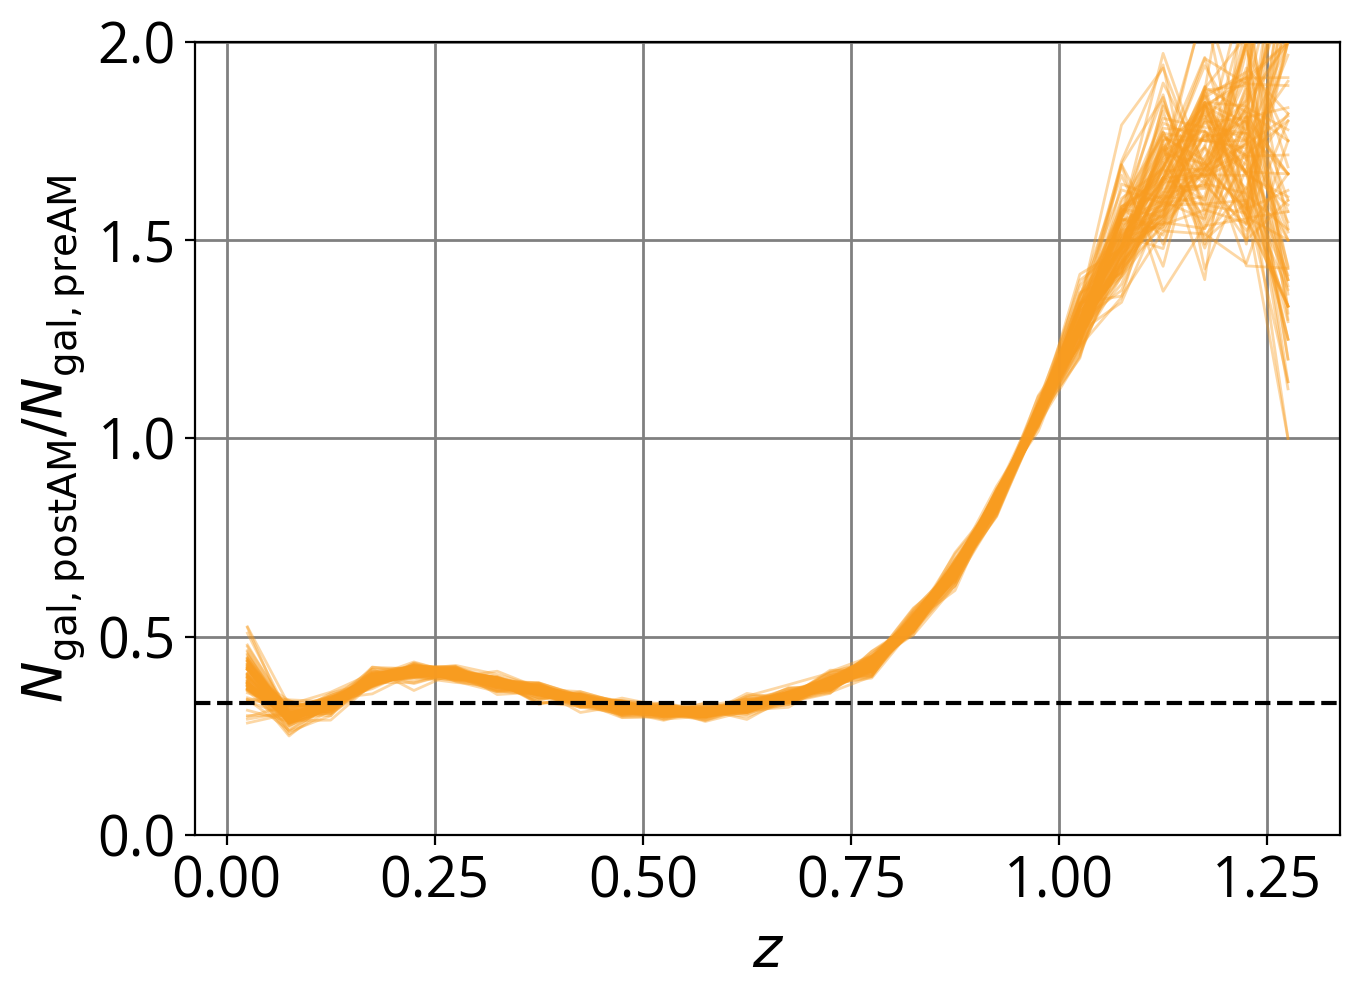

In [30]:
zbin = np.linspace(0, 2, 41)

for i in range(32):
    for f in ["D02", "D03", "D10"]:
        fsel_og = (D10calcat["Field"] == f) & (D10calcat["LCno"] == i + 1) & msel_og & comp_sel
        fsel_corr = (D10calcat["Field"] == f) & (D10calcat["LCno"] == i + 1) & msel_corr & comp_sel
        Ngal_og = np.histogram(D10calcat.loc[fsel_og, "zobs"].to_numpy(copy = True),
                               bins = zbin, density = False)[0]
        Ngal_corr = np.histogram(D10calcat.loc[fsel_corr, "zobs"].to_numpy(copy = True),
                                 bins = zbin, density = False)[0]
        sp.plot((zbin[1:]+zbin[:-1])/2, Ngal_corr/Ngal_og, color = "C1", alpha = 0.4, lw = 1, ylim = (0, 2),
                xlabel = "$z$", ylabel = r"$N^{}_\mathrm{gal,postAM}/N^{}_\mathrm{gal,preAM}$")
sp.axline(y = 1 / 3.0, c = "k", ls = "dashed")
# That 0.05 factor is the bin width correction

plot.tight_layout()
#plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz_allLC.pdf")
#plot.savefig("/home/mbravo/Documents/Group_Finder/GF_runs/Plots/SHARK_DEVILS_Nz_allLC.png")
plot.show()

This was just to check how many galaxies live at one of the edges of the ligthcones. At least in my case the fraction is negligible.

In [15]:
flagsel = D10calcat["Stingray_flag"] < 2
print(f"Fraction of the galaxies removed by the flag selection  =  {np.sum(~flagsel) / len(flagsel):.5f}")
D10calcat = D10calcat.loc[flagsel]

Fraction of the galaxies removed by the flag selection  =  0.00462


In [16]:
D10calcat.to_csv("/home/mbravo/Documents/Group_Finder/LC_runs/DEVILS_CalCat_250212.csv", index = False)